[TOC](../toc.ipynb)

Linear algebraic equations
===========================


- KEYWORDS: numpy.linalg.solve



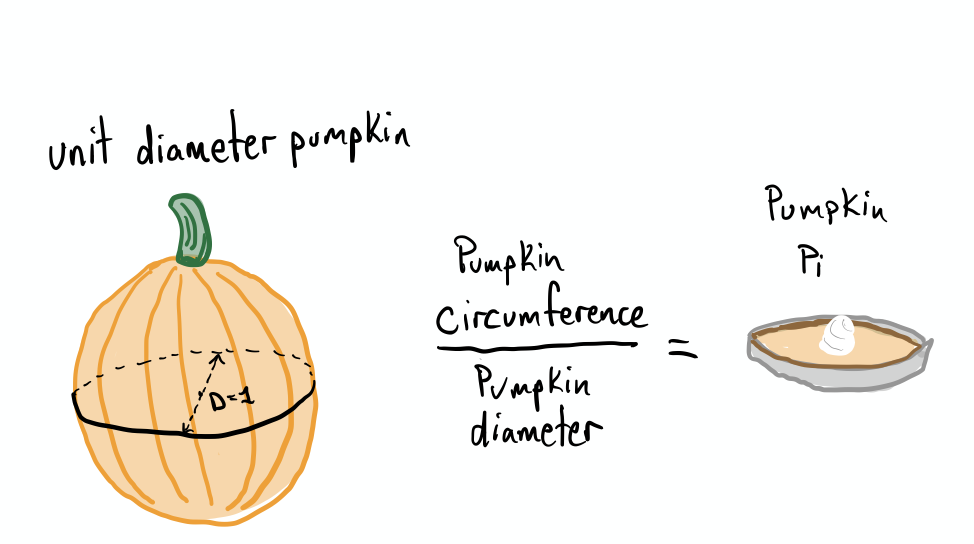



Linear algebra is used extensively in engineering applications. Here we consider some examples.





### Application in reaction engineering - Steady state CSTR





Suppose we have first order reactions occurring in a CSTR. We can represent the concentrations of each species in the reactor as a vector: $C = [C_A, C_C, C_D, ...]$.

Let the reactions be $A \rightarrow C$ and $C \rightarrow D$. These reactions happen at these rates:

$r_1 = k_1 C_A$ and $r_2 = k_2 C_C$.

We assume a constant volume $V$, and volumetric flow rate $\nu$ into a CSTR, and steady state. It is convenient to define $\tau = V / \nu$. With these assumptions, we can derive the following species mole balances:

$0 = C_{A, feed} - C_A - \tau k_1 C_A$

$0 = C_{C, feed} - C_C + \tau k_1 C_A - \tau k_2 C_C$

$0 = C_{D, feed} - C_D + \tau k_2 C_C$

These are not particularly in a useful form, since they do not resemble $\mathbf{A} \mathbf{x} = \mathbf{b}$. We can rearrange them to achieve that. We need all the variables on the left, and any constant terms on the right.

$C_A + \tau k_1 C_A = C_{A, feed}$

$C_C - \tau k_1 C_A + \tau k_2 C_C = C_{C, feed}$

$C_D - \tau k_2 C_C = C_{D, feed}$

Now, we can start to see some structure emerge. Let $\mathbf{C} = [C_A, C_C, C_D]$.

Let $\mathbf{A} = \left[\begin{array}{ccc}
 1 + \tau k_1 & 0 & 0 \\
 -\tau k_1 & 1 + \tau k_2 & 0 \\
 0 & -\tau k_2 & 1
 \end{array}\right]$

and finally, we have $\mathbf{C_{feed}} = [C_{A,feed}, C_{C, feed}, C_{D, feed}]$. Or, all together:

$\mathbf{A} \mathbf{C} = \mathbf{C_{feed}}$.

Note that we have been talking about these as linear equations, but,  we may also think of them as transformations. Consider this:

$\mathbf{A}^{-1} \mathbf{C_{feed}} = \mathbf{C}$.

Here we can see that $\mathbf{A}^{-1}$ transforms the feed concentrations into the exit concentrations.

Solving these equations is now straightfoward:



In [2]:
import numpy as np

tau = 2.5  # Residence time (min)
C_feed = [2.2, 0.0, 0.0]  # mol / L
k1 = 2.3  # 1/min
k2 = 4.5  # 1/min

A = np.array([[1 + tau * k1,  0.0,           0.0], 
              [-tau * k1,     1 + tau * k2,  0.0], 
              [0.0,          -tau * k2,      1]])

C_A, C_C, C_D = np.linalg.solve(A, C_feed)

print(f"The exit concentrations are C_A={C_A:1.2f} M, C_C={C_C:1.2f} M, C_D={C_D:1.2f} M")



The exit concentrations are C_A=0.33 M, C_C=0.15 M, C_D=1.72 M


You can check your answer with other ways.



In [3]:
sol = np.linalg.inv(A) @ C_feed

with np.printoptions(precision=2):
    print(f"sol = {sol}")



sol = [0.33 0.15 1.72]


And we can see the solution works like this, e.g. A @ C = C_feed



In [8]:
A @ [C_A, C_C, C_D], C_feed

(array([ 2.20000000e+00,  0.00000000e+00, -2.22044605e-16]), [2.2, 0.0, 0.0])

In [9]:
np.allclose(A @ [C_A, C_C, C_D], C_feed)



True

#### Alternative approach with root

This has different advantages and disadvantages than the linear approach.

In [11]:
Cafeed, Ccfeed, Cdfeed = C_feed
def cstr(C):
    Ca, Cc, Cd = C
    z1 = Cafeed - Ca - tau * k1 * Ca
    z2 = Ccfeed - Cc + tau * k1 * Ca - tau * k2 * Cc
    z3 = Cdfeed - Cd + tau * k2 * Cc
    return z1, z2, z3

from scipy.optimize import root
sol = root(cstr, [1, 1, 1])

with np.printoptions(precision=2):
    print(sol.x)
    

[0.33 0.15 1.72]


We can also see that the matrix is rank 3, with a non-zero determinant, so for three unknowns, we expect a unique solution.



In [12]:
np.linalg.matrix_rank(A)

3

In [13]:
np.linalg.det(A)

82.6875

### Finding independent reactions





reference: Exercise 2.4 in Chemical Reactor Analysis and Design Fundamentals by Rawlings and Ekerdt.

The following reactions are proposed in the hydrogenation of bromine. The reactions are defined by $\mathbf{M} \mathbf{v}$  where $\mathbf{M}$ is a stoichometric matrix in which each row represents a reaction with negative stoichiometric coefficients for reactants, and positive stoichiometric coefficients for products. A stoichiometric coefficient of 0 is used for species not participating in the reaction.  The species vector is $\mathbf{v}$ = [H2 H Br2 Br HBr].T





In [14]:
#              [H2  H Br2  Br  HBr]
M = np.array([[-1, 0, -1, 0, 2],  # H2 + Br2 == 2HBr
              [0, 0, -1, 2, 0],   # Br2 == 2Br
              [-1, 1, 0, -1, 1],  # Br + H2 == HBr + H
              [0, -1, -1, 1, 1],  # H + Br2 == HBr + Br
              [1, -1, 0, 1, -1],  # H + HBr == H2 + Br
              [0, 0, 1, -2, 0]])  # 2Br == Br2



We can check to see how many independent rows there are, this is equal to the rank of the matrix.



In [15]:
np.linalg.matrix_rank(M)

3

You can see based on this result that there are only three independent equations. Now we consider how to identify three of them. We need to manipulate $\mathbf{M}$ to eliminate at least three rows. We can see by inspection that rows 1 and 5 are linearly related. If we add row 1 to row 5, we will get a row of zeros. That means these two rows are linearly dependent.





In [16]:
M



array([[-1,  0, -1,  0,  2],
       [ 0,  0, -1,  2,  0],
       [-1,  1,  0, -1,  1],
       [ 0, -1, -1,  1,  1],
       [ 1, -1,  0,  1, -1],
       [ 0,  0,  1, -2,  0]])

In [17]:
M[5] += M[1]  # This modifies the array: M[5] = M[5] + M[1]
M



array([[-1,  0, -1,  0,  2],
       [ 0,  0, -1,  2,  0],
       [-1,  1,  0, -1,  1],
       [ 0, -1, -1,  1,  1],
       [ 1, -1,  0,  1, -1],
       [ 0,  0,  0,  0,  0]])

Further inspection shows Row 0 is the sum of rows 2 and 3.





In [18]:
M[0] -= M[2] + M[3]
M



array([[ 0,  0,  0,  0,  0],
       [ 0,  0, -1,  2,  0],
       [-1,  1,  0, -1,  1],
       [ 0, -1, -1,  1,  1],
       [ 1, -1,  0,  1, -1],
       [ 0,  0,  0,  0,  0]])

Finally reaction 2 is the opposite of reaction 4





In [19]:
M[2] += M[4]
M



array([[ 0,  0,  0,  0,  0],
       [ 0,  0, -1,  2,  0],
       [ 0,  0,  0,  0,  0],
       [ 0, -1, -1,  1,  1],
       [ 1, -1,  0,  1, -1],
       [ 0,  0,  0,  0,  0]])

We have successfully eliminated three reactions by linear combinations of other reactions. We can reorder the array like this to put the non-zero rows at the top.





In [20]:
M[[1, 3, 4, 0, 2, 5]]  # indexing to reorder the array



array([[ 0,  0, -1,  2,  0],
       [ 0, -1, -1,  1,  1],
       [ 1, -1,  0,  1, -1],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

It would be nice to print these in a more readable form. That requires some iteration, and combining the labels and coefficients. 

```{sidebar}
We review some ways to do this here.
```



In [21]:
for a, b in zip([1, 2, 3, 4], 
                ["a", "b", "c", "d"]):
    print(a, b)

1 a
2 b
3 c
4 d


Or alternatively using enumerate



In [22]:
B = ["a", "b", "c", "d"]
for i, a in enumerate([1, 2, 3, 4]):
    print(a, B[i])

1 a
2 b
3 c
4 d


This also works, but is considered old-fashioned.



In [23]:
A = [1, 2, 3, 4]
for i in range(4):
    print(A[i], B[i])



1 a
2 b
3 c
4 d


Now we consider a few different ways we can combine these. First, we use an "equation" form where everything is on the right hand side, and we use a sign to indicate (-) reactants and (+) products. The sign is entered in the format string with +.



In [26]:
labels = ["H2", "H", "Br2", "Br", "HBr"]
for row in M[[1, 3, 4, 0, 2, 5]]:
    s = "0 = "
    for nu, species in zip(row, labels):
        s += f" {int(nu):+d}{species}"
    print(s)



0 =  +0H2 +0H -1Br2 +2Br +0HBr
0 =  +0H2 -1H -1Br2 +1Br +1HBr
0 =  +1H2 -1H +0Br2 +1Br -1HBr
0 =  +0H2 +0H +0Br2 +0Br +0HBr
0 =  +0H2 +0H +0Br2 +0Br +0HBr
0 =  +0H2 +0H +0Br2 +0Br +0HBr


That is not too beautiful. We usually do not include reactants with stoichiometric coefficients of 0. Next, we eliminate those. Some rows are all 0, so we eliminate those too.



In [27]:
labels = ["H2", "H", "Br2", "Br", "HBr"]
for row in M:
    if not np.all(row == 0):  # ignore rows that are all zeros
        s = "0 = "
        for nu, species in zip(row, labels):
            if nu != 0:
                s += f" {int(nu):+d}{species}"
        print(s)



0 =  -1Br2 +2Br
0 =  -1H -1Br2 +1Br +1HBr
0 =  +1H2 -1H +1Br -1HBr


That representation is a little clunky, but it is tricky to get more conventional looking reactions. Here we accumulate strings in a list, and then we join them.



In [30]:
" + ".join(["a", "b", "c", "d"])  # joining a list of string

'a + b + c + d'

In [31]:
labels = ["H2", "H", "Br2", "Br", "HBr"]
for row in M:
    if not np.all(row == 0):
        reactants, products = [], []
        for nu, species in zip(row, labels):
            if nu < 0:
                reactants += [f' {"" if nu == -1 else -int(nu)}{species}']
            elif nu > 0:
                products += [f' {"" if nu == 1 else int(nu)}{species}']
        reactants = " + ".join(reactants)
        products = " + ".join(products)
        print(f"{reactants} -> {products}")



 Br2 ->  2Br
 H +  Br2 ->  Br +  HBr
 H +  HBr ->  H2 +  Br


What we did by hand was to put the matrix into reduced row echelon form. It is not common to do this by hand. One way to get the computer to do this for you is to use [sympy](https://www.sympy.org/en/index.html). This is a symbolic math package for Python that is similar to Mathematica and Maple in its ability to do symbolic (as opposed to numeric) manipulations.





In [32]:
import sympy

sympy.Matrix.rref?



Signature:
sympy.Matrix.rref(
    self,
    iszerofunc=<function _iszero at 0x7f72d45f1700>,
    simplify=False,
    pivots=True,
    normalize_last=True,
)
Docstring:
Return reduced row-echelon form of matrix and indices of pivot vars.

Parameters

iszerofunc : Function
    A function used for detecting whether an element can
    act as a pivot.  ``lambda x: x.is_zero`` is used by default.

simplify : Function
    A function used to simplify elements when looking for a pivot.
    By default SymPy's ``simplify`` is used.

pivots : True or False
    If ``True``, a tuple containing the row-reduced matrix and a tuple
    of pivot columns is returned.  If ``False`` just the row-reduced
    matrix is returned.

normalize_last : True or False
    If ``True``, no pivots are normalized to `1` until after all
    entries above and below each pivot are zeroed.  This means the row
    reduction algorithm is fraction free until the very last step.
    If ``False``, the naive row reduction procedur

We can convert the `Matrix` to an array like this.



From here you can use the code from above to construct the equations.





In [33]:
reduced_form, pivots = sympy.Matrix(M).rref()



In [40]:
np.array(reduced_form).astype(int)



array([[ 1,  0,  0,  2, -2],
       [ 0,  1,  0,  1, -1],
       [ 0,  0,  1, -2,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [41]:
labels = ["H2", "H", "Br2", "Br", "HBr"]
for row in np.array(reduced_form):
    if not np.all(row == 0):
        reactants, products = [], []
        for nu, species in zip(row, labels):
            if nu < 0:
                reactants += [f' {"" if nu == -1 else -nu}{species}']
            elif nu > 0:
                products += [f' {"" if nu == 1 else nu}{species}']
        reactants = " + ".join(reactants)
        products = " + ".join(products)
        print(f"{reactants} -> {products}")

 2HBr ->  H2 +  2Br
 HBr ->  H +  Br
 2Br ->  Br2


### Application in linear boundary value problems





Let us consider pressure driven flow again.

$\frac{d^2 v_x}{dy^2} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

This is a boundary value problem where $v_x(y=0) = 0$ and $v_x(y=B) = 0$. The solution is well-known and parabolic.

We previously used `scipy.integrate.solve_bvp` for this. Recall that it is necessary to create an initial guess of the solution, and that can be tricky. Here we consider an alternative approach to solving it using a method of finite differences.

We can write the second derivative as an approximate finite difference formula:

$f''(x) \approx \frac{f(x + h) - 2 f(x) + f(x-h)}{h^2}$

Let's discretize the domain and then see if we can solve for the velocity at the discretized points.

At each point, we can estimate the second derivative as:

$\frac{d^2 v}{dy^2} \approx \frac{v_{j+1} - 2 v_j + v_{j-1}}{h^2} = \frac{\Delta P}{\mu\Delta x}$

How does this help us? The $v_j$ are variables that we want to solve for. With a little rearrangement we have:

$v_{j+1} - 2 v_j + v_{j-1} = \frac{h^2 \Delta P}{\mu\Delta x} = G$

Let's write a few of these out, starting at $j=1$ up to $j=N-1$:

$v_2 - 2 v_1 + v_0 = G$

$v_3 - 2 v_2 + v_1 = G$

&#x2026;

$v_{N} - 2 v_{N-1} + v_{N-2} = G$

If we define $\mathbf{v} = [v_1, v_2, ... v_{N-1}]$ (remember we know $v_0$ and $v_{N}$ from the boundary conditions), we can see the following structure emerge:

Let $\mathbf{A} = \left[\begin{array}{ccccc}
 -2 & 1 & 0 & ... & 0 \\
 1 & -2 & 1 & ...& 0\\
 \vdots\\
 0 & ... & 0 & 1 & -2
 \end{array}\right]$

This matrix is sparse (most entries are zero), and diagonal. The diagonal is always -2, and the diagonal above and below the main diagonal is always 1. Note that some derivations of this move a minus sign into the $\mathbf{G}$, but it does not change anything. Let's consider how to construct a matrix like this.



In [47]:
N = 5
A = np.eye(N) * -2
L = np.diag(np.ones(N - 1), -1)  # diagonal below the main
U = np.diag(np.ones(N - 1), 1)  # diagonal above the main
A + L + U



array([[-2.,  1.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  1., -2.]])

And we can define $\mathbf{G} = [G - v_0, G, G, ..., G - v_N]$ so that we have the following linear equation that is easy to solve:

$\mathbf{A} \mathbf{v} = \mathbf{G}$. The only issue is how to code this up conveniently?





In [51]:
B = 0.2  # height of channel

N = 100  # You need to use enough points to make sure the derivatives are
# reasonably approximated

y, h = np.linspace(0, B, N, retstep=True)

A = np.eye(len(y) - 2) * -2
L = np.diag(np.ones(len(y) - 3), -1)  # lower diagonal
U = np.diag(np.ones(len(y) - 3), 1)  # upper diagonal
A = A + L + U
A  # always a good idea to check we have the right structure.



array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

Now we create the $\mathbf{G}$ vector.





In [60]:
mu = 2
deltaPx = -50
v0, vB = 0.0, 0.0

G = np.ones(len(y) - 2) * deltaPx / mu * h**2
G[0] -= v0
G[-1] -= vB
A.shape, G.shape

((98, 98), (98,))

Now, solving this is simple, no initial guesses required since it is a linear problem.





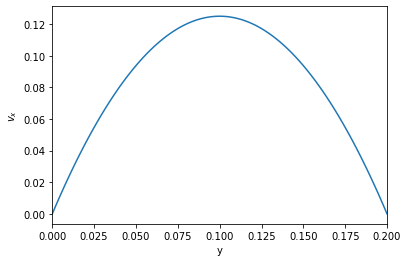

In [61]:
vx = np.linalg.solve(A, G)

import matplotlib.pyplot as plt

plt.plot(y, np.concatenate([[v0], vx, [vB]]))
plt.xlabel("y")
plt.ylabel("$v_x$")
plt.xlim([0, B]);

Note that we have approximated the solution by discretizing and estimating the derivatives at the points. You have to check for convergence by increasing the number of points $N$.

This method worked because the BVP was *linear*, i.e. no products, powers, etc of derivatives, so that the final set of equations after discretization was linear. If the BVP was nonlinear, we would end up with a set of coupled nonlinear equations that you would have to use `scipy.optimize.root` to solve, or `scipy.integrate.solve_bvp`, and these would both require an initial guess to solve.





## Things to look out for





Just because systems are linear doesn't mean they are well-behaved. Seemingly simple equations can show unexpected behavior. Consider

$-0.5 x1 + x2 = 1.1$

and

$-0.46 x1 + x2 = 1.0$

These are easy to solve.





In [62]:
import numpy as np

A = np.array([[-0.5, 1], 
              [-0.46, 1]])
b = np.array([1.1, 1])

np.linalg.solve(A, b)



array([-2.5 , -0.15])

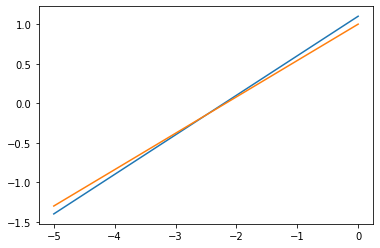

In [63]:
import matplotlib.pyplot as plt

x1 = np.linspace(-5, 0)
x21 = 1.1 + 0.5 * x1
x22 = 1.0 + 0.46 * x1

plt.plot(x1, x21, x1, x22);



Now consider this slightly different system where we just change -0.46 to -0.47. Surely that should not be a big deal right?





In [90]:
A = np.array([[-0.5, 1], 
              [-0.49, 1]])

b = np.array([1.1, 1])

np.linalg.solve(A, b)



array([-10. ,  -3.9])

That seems like a big change in the answer for such a small change in one coefficient. What is happening? The determinant of this matrix is small, and the condition number is high, which means it is an ill-conditioned system of equations.





In [65]:
np.linalg.det(A), np.linalg.cond(A)



(-0.030000000000000023, 82.3511902180071)

In [69]:
np.linalg.matrix_rank(A)



2

In [70]:
sympy.Matrix(A).rref()



(Matrix([
 [1, 0],
 [0, 1]]),
 (0, 1))

In [71]:
A



array([[-0.5 ,  1.  ],
       [-0.47,  1.  ]])

In [72]:
A[1] -= A[0]
A



array([[-0.5 ,  1.  ],
       [ 0.03,  0.  ]])

Graphically, this means the two lines are nearly parallel, so even the smallest shift in the slope will result in a large change in the intersection.





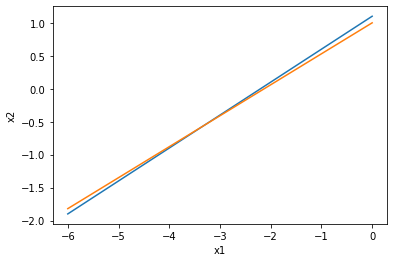

In [73]:
import matplotlib.pyplot as plt

x1 = np.linspace(-6, 0)
x2_0 = 1.1 + 0.5 * x1
x2_1 = 1.0 + 0.47 * x1

plt.plot(x1, x2_0, x1, x2_1)
plt.xlabel("x1")
plt.ylabel("x2");



This system of equations is sensitive to roundoff errors, both in the coefficients of $\mathbf{A}$ and in the numerics of solving the equations.





## Leveraging linear algebra for iteration





Linear algebra can be used for iteration (for loops) in some cases. Doing this is usually faster because dedicated linear algebra libraries are very fast, and the code is usually shorter. However, it is trickier to write sometimes, and not everything can be done this way.

It can also be advantageous to use this approach in machine learning. Some frameworks are difficult to use loops in.

The dot product is defined as:

$\mathbf{a}\cdot\mathbf{b} = \sum_{i=0}^{N-1} a_i b_i$

For specificity we have these two vectors to start with:





In [124]:
import numpy as np

a = np.array([1, 2, 3, 4, 5])
b = np.array([3, 6, 8, 9, 10])

a = np.random.uniform(size=100)
b = np.random.uniform(size=100)

As defined, we could implement the dot product as:





In [125]:
%%timeit
dp = 0
for i in range(len(a)):
    dp += a[i] * b[i]

dp

32 µs ± 49.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [126]:
%%timeit
dp = 0
for ai, bi in zip(a, b):
    dp += ai * bi
dp

22 µs ± 595 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We can do better than that with elementwise multiplication:





In [127]:
%%timeit
np.sum(a * b)



5 µs ± 12.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The best approach, however, is the linear algebra approach:





In [128]:
%%timeit
a @ b


1.4 µs ± 5.72 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [129]:
%%timeit
np.dot(a, b)

1.36 µs ± 0.972 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Why is this better?

1.  It is short.
2.  It does not specify how the computation is done. This allows it to be done with an optimized (i.e. fast) and possibly parallelized algorithm. *Many* very smart people have worked hard to make linear algebra fast; we should try not to implement it ourselves.

Consider $y = \sum\limits_{i=1}^n w_i x_i^2$. This operation is like a weighted sum of squares.

The old-fashioned way to do this is with a loop.





In [98]:
w = np.array([0.1, 0.25, 0.12, 0.45, 0.98])
x = np.array([9, 7, 11, 12, 8])





162.39

In [107]:
%%timeit
y = 0
for wi, xi in zip(w, x):
    y += wi * xi**2
y

2.83 µs ± 55 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Compare this to the more modern numpy approach.





In [108]:
%%timeit
y = np.sum(w * x**2)
y



9.02 µs ± 32.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


We can also express this in matrix algebra form. The operation is equivalent to $y = \mathbf{x} \cdot \mathbf{D_w} \cdot \mathbf{x}^T$ where $\mathbf{D_w}$ is a diagonal matrix with the weights on the diagonal.

In the formula above $\mathbf{x}$ is a row vector and $\mathbf{x}^T$ is a column vector.




In [113]:
X = np.array([x])
X.shape, X.T.shape

W = np.diag(w)

1 x 5 @ 5 x 5 @ (5 x 1)



In [114]:
%%timeit
(X @ W @ X.T)



5.11 µs ± 45.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [111]:
np.diag(w)



array([[0.1 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.45, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.98]])

In [116]:
%%timeit
x @ np.diag(w) @ x



7.23 µs ± 64.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Finally, consider the sum of the product of three vectors. Let $y = \sum\limits_{i=1}^n w_i x_i y_i$. This is like a weighted sum of products.





In [117]:
w = np.array([0.1, 0.25, 0.12, 0.45, 0.98])
x = np.array([9, 7, 11, 12, 8])
y = np.array([2, 5, 3, 8, 0])

print(np.sum(w * x * y))  # numpy vectorized approach
w @ np.diag(x) @ y  # linear algebra approach



57.71


57.71

**Reflective Questions**



In [ ]:
from f22_06623 import MCQ
MCQ(lecture='16_linear_algebra')



## Summary





In this lecture we considered several applications of linear algebra including:

1.  Solutions to steady state mass balances
2.  Finding independent reactions
3.  Solving linear boundary value problems

We also briefly touched on vectorized approaches to using linear algebra to avoid writing explicit loops.



